# Geospatial peak activity forecast

In this project, I aimed to find a solution to direct drivers towards areas of peak demand ahead of time. For this, I used a ride hailing dataset and predicted areas of high demand in space and time.

# Setup

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
import geopy.distance
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import h3
from pandas import to_datetime
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load data
whole_data = pd.read_csv('./data/dataset.csv')

In [3]:
# check size of dataframe
whole_data.shape[0]

627210

In [4]:
# randomly subsample 100k rows to reduce data size and make code run faster

# seed for reproducibility
random.seed(42)

# subsample 10,000 rows
data = whole_data.sample(n=10000, random_state=42)

# Data Exploration

In [5]:
data.head()

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value
55666,2022-03-24 12:08:16.023462000,59.418367,24.694892,59.401600,24.669310,0.58500
218791,2022-03-15 21:11:01.886894000,59.507552,24.830726,59.434191,24.711306,2.62475
404313,2022-03-18 00:38:18.166059000,59.444910,24.750818,59.384779,24.727367,1.70000
33445,2022-03-23 20:02:08.131612000,59.396727,24.667368,59.397948,24.651710,0.21975
327754,2022-03-12 00:11:42.931471000,59.438570,24.724982,59.419126,24.798727,1.15675


In [6]:
# check for missing values values
data.isnull().any()

start_time    False
start_lat     False
start_lng     False
end_lat       False
end_lng       False
ride_value    False
dtype: bool

In [7]:
# check for nan values
data.isna().any()

start_time    False
start_lat     False
start_lng     False
end_lat       False
end_lng       False
ride_value    False
dtype: bool

In [8]:
# check if any column contains non-numeric values
data.select_dtypes(exclude='number').columns

Index(['start_time'], dtype='object')

In [9]:
# determine data format
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 55666 to 356244
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   start_time  10000 non-null  object 
 1   start_lat   10000 non-null  float64
 2   start_lng   10000 non-null  float64
 3   end_lat     10000 non-null  float64
 4   end_lng     10000 non-null  float64
 5   ride_value  10000 non-null  float64
dtypes: float64(5), object(1)
memory usage: 546.9+ KB


In [10]:
# convert start_time to datetime format
data['start_time'] = pd.to_datetime(data['start_time'])

#### 1) Explore temporal variables

In [11]:
# since this will be a time series problem, sort in chronological order
data = data.sort_values(by='start_time', ascending=True)

In [12]:
# make new columns to explore temporal features
data['year'] = data['start_time'].dt.year
data['month'] = data['start_time'].dt.month
data['day'] = data['start_time'].dt.day
data['hour'] = data['start_time'].dt.hour
data['minute'] = data['start_time'].dt.minute
data['dayname'] = data['start_time'].dt.day_name()

In [13]:
# make seperate year column to see how many years are included in dataset
data.year.unique()

array([2022], dtype=int32)

In [14]:
# since all data is from 2022, we can remove the 'year' column again
data.drop('year', axis=1, inplace=True)

In [15]:
# make seperate month column to see how many moths are included in dataset
data.month.unique()

array([3], dtype=int32)

In [16]:
# all data is from March, so we don't need a 'month' column
data.drop('month', axis=1, inplace=True)

In [17]:
# look at days
np.sort(data.day.unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28], dtype=int32)

So overall the data is from March 2022, ranging from 1st until 28th of March

We are interested in the ride frequency in time and space, so we will first plot the number of ride requests in different time windows

In [18]:
# ride frequency per hour
hourly_rides = data.groupby('hour').size()

# ride frequency per weekday
weekday_rides = data.groupby('dayname').size().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])

# ride frequency by day of month
month_rides = data.groupby('day').size()

In [19]:
# also determine ride values across different time windows
ride_value_by_hour    = pd.DataFrame(data.groupby('hour')['ride_value'].sum())
ride_value_by_weekday = pd.DataFrame(data.groupby('dayname')['ride_value'].sum()).reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])
ride_value_by_month = data.groupby('day')['ride_value'].sum()

#### Plot ride frequency and value over different time windows

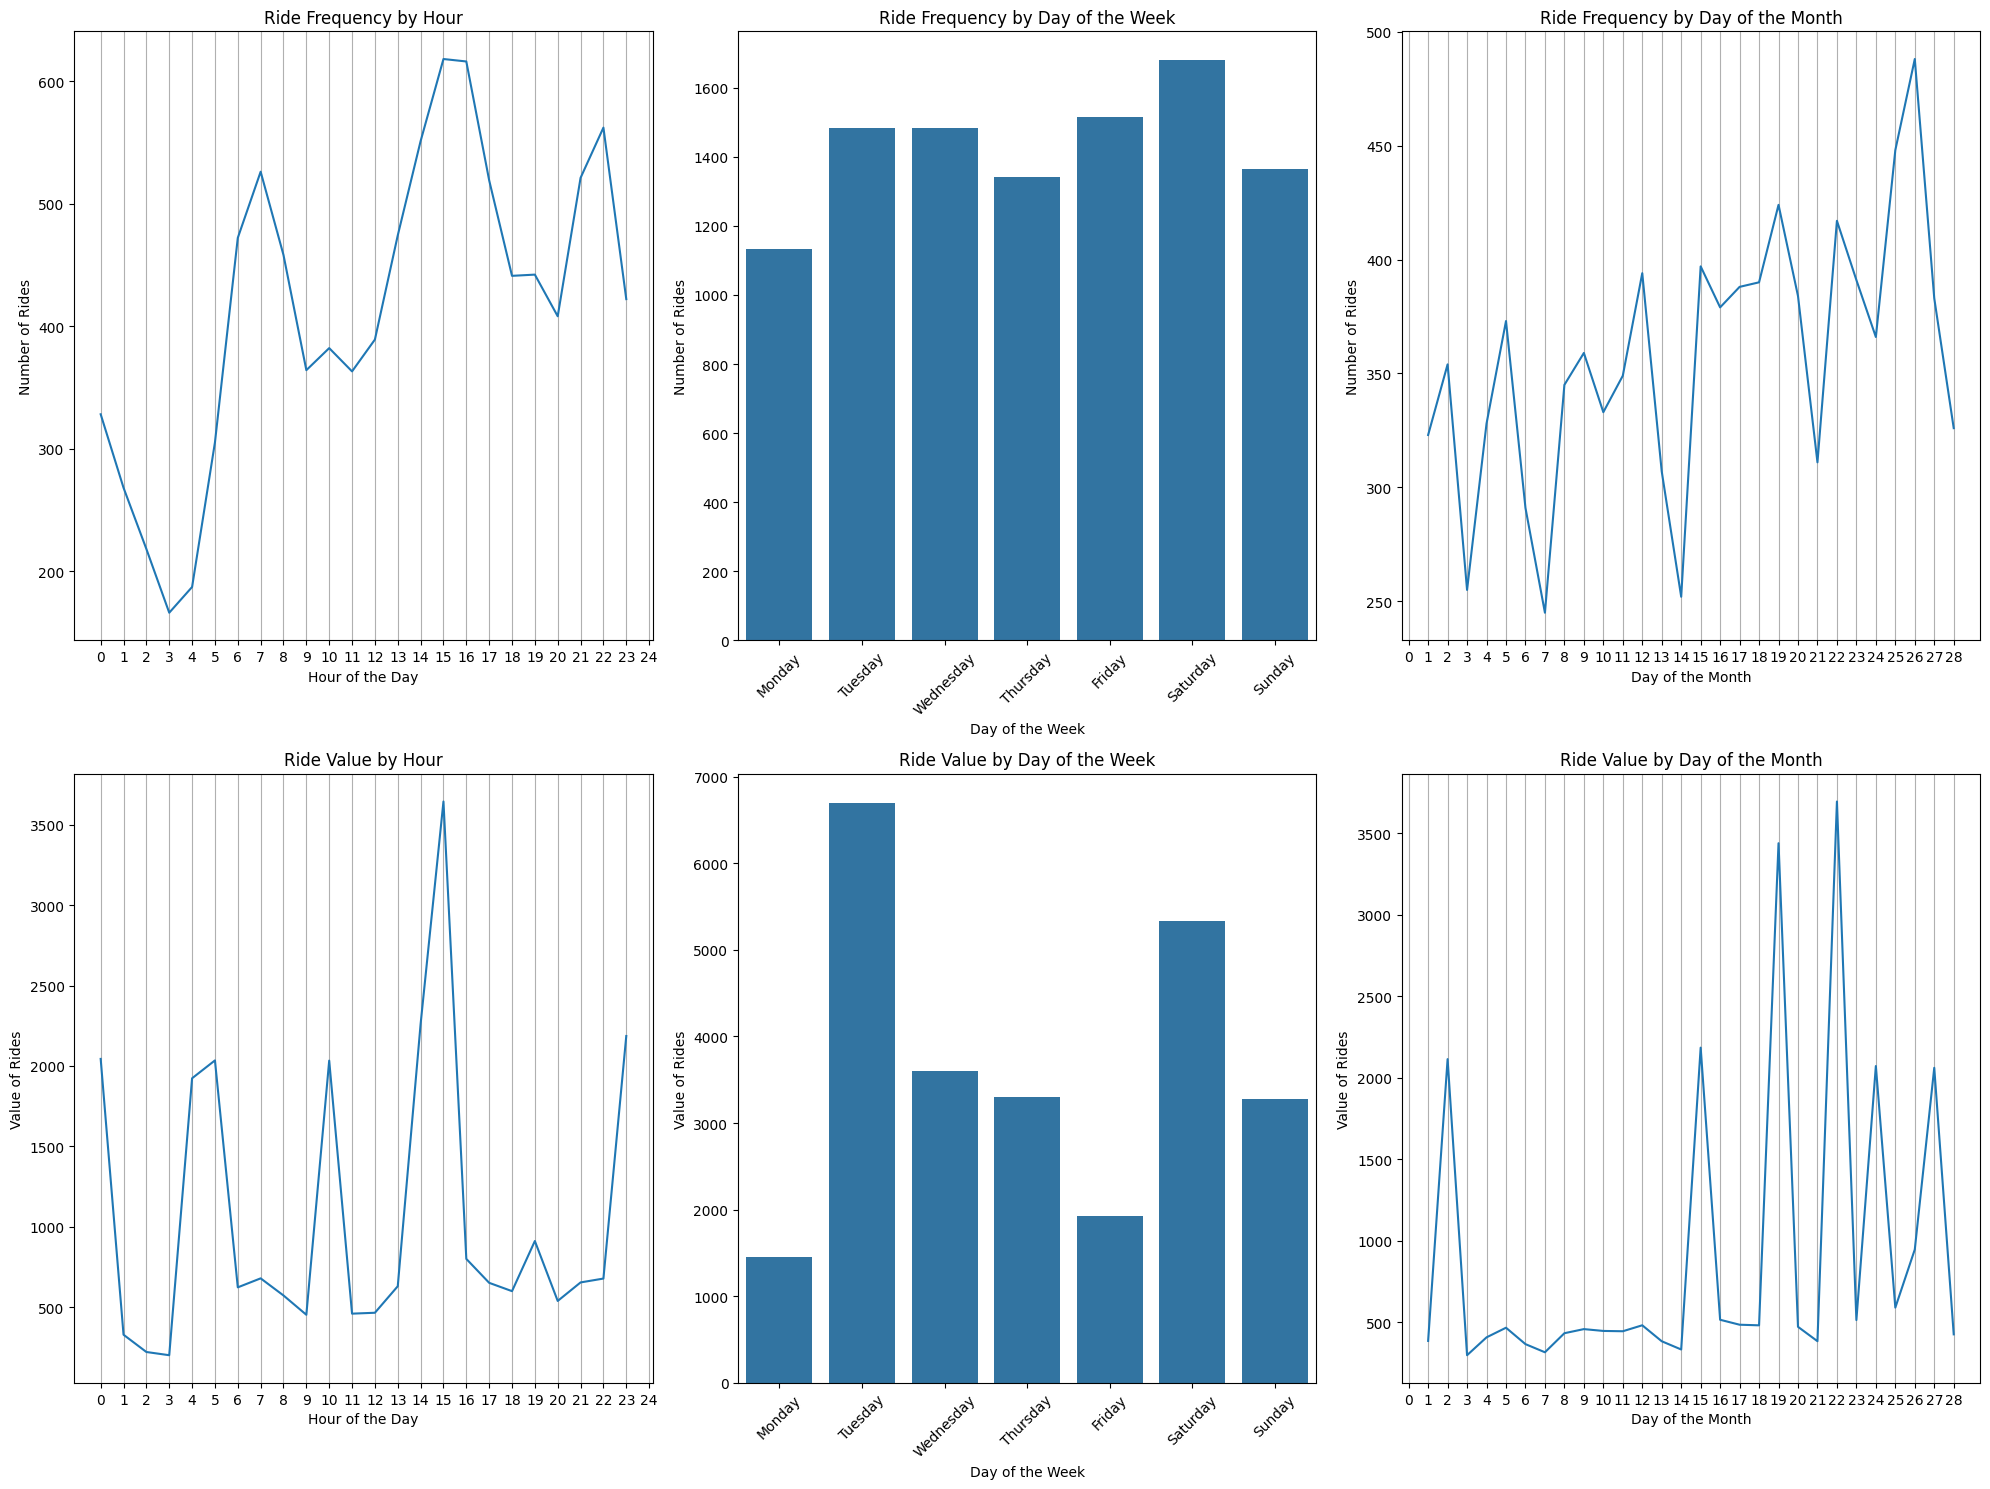

In [20]:
plt.figure(figsize=(20, 15))

plt.subplot(2, 3, 1)
plt.plot(hourly_rides)
plt.xticks(np.arange(0, 25, 1)) 
plt.grid(axis="x")
plt.title('Ride Frequency by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Rides')

plt.subplot(2, 3, 2)
sns.barplot(weekday_rides)
plt.title('Ride Frequency by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Rides')
plt.xticks(rotation=45)

plt.subplot(2, 3, 3)
plt.plot(month_rides)
plt.xticks(np.arange(0, 29, 1)) 
plt.grid(axis="x")
plt.title('Ride Frequency by Day of the Month')
plt.xlabel('Day of the Month')
plt.ylabel('Number of Rides')

plt.subplot(2, 3, 4)
plt.plot(ride_value_by_hour)
plt.xticks(np.arange(0, 25, 1)) 
plt.grid(axis="x")
plt.title('Ride Value by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Value of Rides')

plt.subplot(2, 3, 5)
sns.barplot(x="dayname", y="ride_value", data=ride_value_by_weekday)
plt.title('Ride Value by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Value of Rides')
plt.xticks(rotation=45)

plt.subplot(2, 3, 6)
plt.plot(ride_value_by_month)
plt.xticks(np.arange(0, 29, 1)) 
plt.grid(axis="x")
plt.title('Ride Value by Day of the Month')
plt.xlabel('Day of the Month')
plt.ylabel('Value of Rides')

plt.tight_layout()
plt.show()

There is a peak in ride hails in the mornings and afternoons around work times, likely from weekdays. Then there is another peak around 10 pm, likely from weekends. The weekly peak is on Saturdays. Over the month, it looks like there is seasonality over weeks and an upwards trend across the month. The ride values follow a similar pattern except for the weekdays, where Tuesday is the most profitable day.

#### 2) Explore data in space

Let's explore the distribution of ride frequency in space

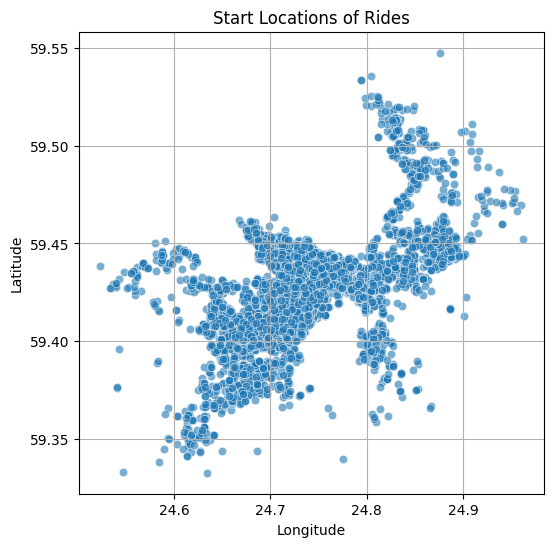

In [21]:
# scatter plot of ride requests
plt.figure(figsize=(6, 6))
sns.scatterplot(x='start_lng', y='start_lat', data=data, alpha=0.6)
plt.grid()
plt.title('Start Locations of Rides')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Since here the datapoints are overlaid, it's more informative to look at a heatplot to get an idea of the frequency distribution of starting locations

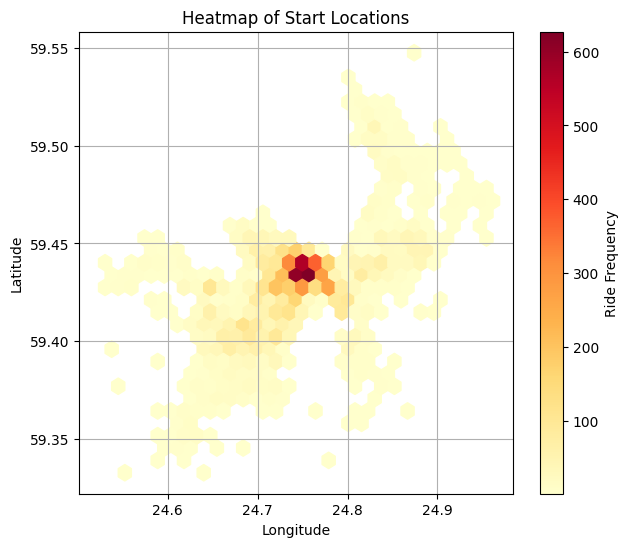

In [22]:
# plot heatmap to visualize high frequency locations
plt.figure(figsize=(7, 6))

plt.hexbin(data['start_lng'], data['start_lat'], gridsize=30, cmap='YlOrRd', mincnt=1)
plt.grid()
plt.colorbar(label='Ride Frequency')
plt.title('Heatmap of Start Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

This shows a hotspot and some data points that are further away from the hotspot. To get a feeling for how far away the datapoints are from the hotspot and where the hotspot is, we can overlay a heatmap on a map.

In [23]:
# plot heatmap over map to see where hotspots are and how for out of the city rides start
map_center_lat = data['start_lat'].mean()
map_center_lng = data['start_lng'].mean()
map_zoom_start = 12

# create folium map
map = folium.Map(location=[map_center_lat, map_center_lng], zoom_start=map_zoom_start)

# create a HeatMap layer
heat_data = [[row['start_lat'], row['start_lng']] for index, row in data.iterrows()]
HeatMap(heat_data, min_opacity=0.2).add_to(map)

# Display the map
map

The map shows that rides are requested from outside of the city but the hotspots are in the city center.

#### 3) Explore ride distance and value

In [24]:
# get ride distance
ride_distance = []

# loop through every row of the dataset
for index, row in data.iterrows():
    
    # get ride distance in kilometers (destination coordinates minus pickup coordinates)
    start_loc = [row['start_lat'], row['start_lng']]
    end_loc = [row['end_lat'], row['end_lng']]
    distance = geopy.distance.geodesic(start_loc, end_loc).km
    ride_distance.append(distance)

# append distance to data
data['ride_distance'] = ride_distance

In [25]:
# look at descriptive statistics
data.describe()

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value,day,hour,minute,ride_distance
count,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2022-03-15 18:17:49.174417152,59.428750,24.743445,59.394794,24.726424,2.558861,15.205100,12.874200,29.523800,10.884506
min,2022-03-01 00:03:56.713570,59.332647,24.522889,-34.813728,-87.629808,0.115640,1.000000,0.000000,0.000000,0.013458
25%,2022-03-08 23:15:26.235474688,59.419227,24.713315,59.414786,24.707910,0.560250,8.000000,8.000000,14.000000,2.271542
50%,2022-03-16 08:08:11.836513024,59.432230,24.744852,59.430489,24.743967,1.073068,16.000000,14.000000,30.000000,4.361828
75%,2022-03-22 19:26:02.774481664,59.438934,24.768184,59.439057,24.773934,1.703938,22.000000,18.000000,44.000000,6.922519
max,2022-03-28 23:59:08.548562,59.547567,24.961864,60.183182,120.158675,2861.573500,28.000000,23.000000,59.000000,12917.142303
std,NaN,0.021818,0.056202,1.356045,2.277510,49.098585,8.041884,6.488728,17.311534,218.914190


Both ride value and ride distance have a wide range. Therefore, we will plot their distribution. The standard deviation of start_time is likely NaN because it is in datetime format.

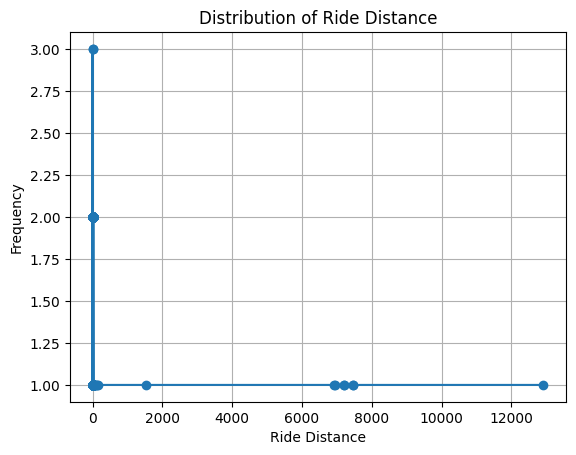

In [26]:
# ride_distance
data['ride_distance'].value_counts().sort_index().plot(marker='o')
plt.title('Distribution of Ride Distance')
plt.xlabel('Ride Distance')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Since some rides seem to be overly far (>10,000 km) or overly close, there seem to be some bad requests in the data and need to be removed during data preprocessing.
Also, the distribution is right-skewed, so it is more informative to look at the median than the mean.

In [27]:
print("Most rides are around %.2f km far" % data['ride_distance'].median())

Most rides are around 4.36 km far


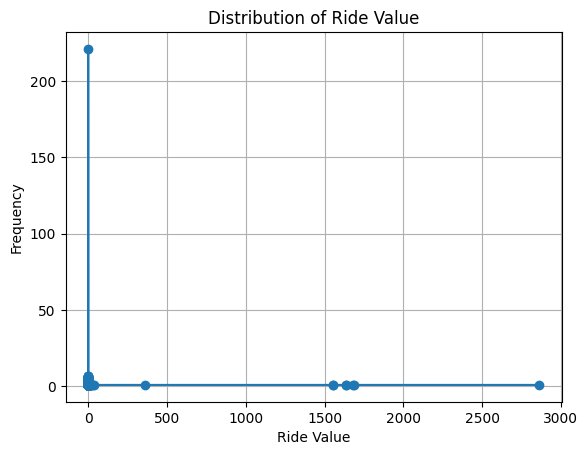

In [28]:
# ride value
data['ride_value'].value_counts().sort_index().plot(marker='o')
plt.title('Distribution of Ride Value')
plt.xlabel('Ride Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

This distribution is also right-skwed, so we compute the median again.

In [29]:
# since the distribution is heavily right-skewed, let's find the median
print("Most rides cost around %.2f Euro" % data['ride_value'].median())

Most rides cost around 1.07 Euro


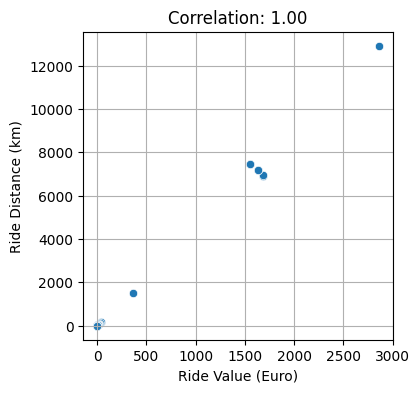

In [30]:
# correlation between ride value and distance
correlation = data['ride_value'].corr(data['ride_distance'])

# plot
plt.figure(figsize=(4, 4))
sns.scatterplot(data=data, x='ride_value', y='ride_distance')
plt.title(f'Correlation: {correlation:.2f}')
plt.xlabel('Ride Value (Euro)')
plt.ylabel('Ride Distance (km)')
plt.grid(True)
plt.show()

As expected, the value of the ride is tighly (perfectly) correlated to the distance of the ride.

# Data Preprocessing

#### 1) Data Cleaning

In [31]:
# first remove bad requests: extremely short or long rides
# based on a quick google maps search I estimate the longest distance between two points by car around 360 km, 
# so we set a generous upper threshold of 400 km
# since the app does not seem to have a minimum distance for ride hailing, we estimate that requests below 100 m are fake

# set thresholds
lower_threshold = 0.1 # 100 m
upper_threshold = 400 # 400 km

# drop rows that are below the lower and above the upper threshold
data_preprocessed = data[(data['ride_distance'] <= upper_threshold) & (data['ride_distance'] >= lower_threshold)]

print("We dropped %.0f rows with unrealistic ride requests" % (data.shape[0]-data_preprocessed.shape[0]))
print("We now have %.0f rows" % (data_preprocessed.shape[0]))

We dropped 30 rows with unrealistic ride requests
We now have 9970 rows


#### 2) Feature engineering

In [32]:
# 1-hot encode dayname variable because it is nominal
data_preprocessed = pd.get_dummies(data_preprocessed, columns=['dayname'])

In [33]:
# create a new column 'is_weekday' with 0 for weekdays and 1 for weekends
weekday_columns = ['dayname_Monday', 'dayname_Tuesday', 'dayname_Wednesday', 'dayname_Thursday', 'dayname_Friday']
data_preprocessed['is_weekday'] = data_preprocessed[weekday_columns].any(axis=1).astype(int)

In [34]:
# check new dataframe columns
data_preprocessed.head()

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value,day,hour,minute,ride_distance,dayname_Friday,dayname_Monday,dayname_Saturday,dayname_Sunday,dayname_Thursday,dayname_Tuesday,dayname_Wednesday,is_weekday
502034,2022-03-01 00:03:56.713570,59.438584,24.707394,59.424473,24.746911,0.67375,1,0,3,2.738836,False,False,False,False,False,True,False,1
559219,2022-03-01 00:12:49.200363,59.435117,24.747638,59.439168,24.764209,0.25575,1,0,12,1.043010,False,False,False,False,False,True,False,1
301782,2022-03-01 00:13:30.753612,59.437496,24.750162,59.411810,24.719233,0.83200,1,0,13,3.357250,False,False,False,False,False,True,False,1
389019,2022-03-01 00:21:39.719871,59.434892,24.747899,59.427245,24.773827,0.41750,1,0,21,1.700356,False,False,False,False,False,True,False,1
87839,2022-03-01 00:31:54.661161,59.412113,24.665203,59.438296,24.748696,1.36725,1,0,31,5.565109,False,False,False,False,False,True,False,1


# Prepare Data for Modelling

We want to build a model that can guide drivers towards busy areas at the right time, so we need predictions in time and space. For this, we will first assign each pick-up coordinate to a hexagon. Then we will split the dataframe by hexagons, yielding one dataframe and time series per hexagon. We can then model the time series for each hexagon individually, yielding a time- and location-specific prediction. This can later be used to predict and display busy areas at specific times, so that drivers can drive towards the areas with higher demand.

#### 1) Split data by hexagons

In [35]:
# get H3 index of each coordinate
my_resolution = 5 # this resolution yields 8 hexagons

def convert_to_h3(row):
    h3_hex = h3.geo_to_h3(row['start_lat'], row['start_lng'], resolution=my_resolution)
    return h3_hex

# assign 'hexagon' ID to to each row
data_preprocessed['hexagon'] = data_preprocessed.apply(convert_to_h3, axis=1)

In [36]:
# split into one dataframe per hexagon, store in dictionary
hexagon_dict = {hex_id: data_preprocessed[data_preprocessed['hexagon'] == hex_id] for hex_id in data_preprocessed['hexagon'].unique()}

# output the number of dictionaries and show their keys (=hexagon ID's) & number of rows (i.e. how many pick ups were within that hexagon 
# over the whole month)
total_hexagons = len(hexagon_dict)
split_summary = {hex_id: len(hexagon_dict[hex_id]) for hex_id in list(hexagon_dict.keys())}

total_hexagons, split_summary

(8,
 {'85089b1bfffffff': 7718,
  '85089bc7fffffff': 2044,
  '85089bcffffffff': 170,
  '85089b0bfffffff': 8,
  '85089b57fffffff': 2,
  '85089b03fffffff': 13,
  '85089b13fffffff': 13,
  '85089bc3fffffff': 2})

A resolution of 5 yielded 8 hexagons, the busiest with over 7k pickups in March 2022, the least busy with only 2 pickups.

#### 2) Prepare data for modelling

In [37]:
# for each hexagon df in hexagon_dict: 
# 1) drop hexagon string column 
# 2) count ride frequency per day. This will be our target variable.

time_bin = 'day'
month_year = '2022-03'

for k, df in hexagon_dict.items():
    
    # Drop hexagon column
    df.drop('hexagon', axis=1, inplace=True)
    
    # Count number of starts per time bin
    starts_count = df.groupby(time_bin)['start_lng'].count().reset_index()

    # Rename column to starts_count
    starts_count = starts_count.rename(columns={'start_lng': 'starts_count'})

    # Append new column to original dataframe
    df = pd.merge(df, starts_count, on=time_bin, how='left')

    # Add datetime column for full timecourse later
    df['datetime'] = to_datetime(month_year + '-' + df['day'].astype(str) + ' ' +
                                 df['hour'].astype(str) + ':' + df['minute'].astype(str))

    # Update the dictionary
    hexagon_dict[k] = df
    
del(k, df)

At the moment, we only have time stamps at the times when there was a pick-up. But we need to also predict when no car is needed, 
so we need a complete time series. 

#### 3) Complete the time series with null events

In [38]:
# prepare datetime column
month_year = '2022-03'
data_preprocessed['datetime'] = to_datetime(month_year + '-' + data['day'].astype(str) + ' ' +
                               data['hour'].astype(str) + ':' + data['minute'].astype(str))

# create a complete datetime range for March 2022
start_date = data_preprocessed['datetime'].min()
end_date = data_preprocessed['datetime'].max()
complete_datetime_range = pd.date_range(start=start_date, end=end_date, freq='T')

# convert the complete_datetime_range to a dataframe
complete_datetime_df = pd.DataFrame(complete_datetime_range, columns=['datetime'])

# add day, hour, minute, and weekday columns to complete_datetime_df
complete_datetime_df['day'] = complete_datetime_df['datetime'].dt.day
complete_datetime_df['hour'] = complete_datetime_df['datetime'].dt.hour
complete_datetime_df['minute'] = complete_datetime_df['datetime'].dt.minute

# Add weekday columns
weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
for i, day in enumerate(weekdays):
    complete_datetime_df[f'dayname_{day}'] = complete_datetime_df['datetime'].dt.dayofweek == i

time_related_columns = ['day', 'hour', 'minute'] + [f'dayname_{day}' for day in weekdays]

# complete each hexagon's dataframe to a complete time series including null event time points
for k, df in hexagon_dict.items():
    
    # drop existing time-related columns if they exist
    df = df.drop(columns=time_related_columns, errors='ignore')

    # Merge the complete datetime range with the existing data
    merged_data = complete_datetime_df.merge(df, on='datetime', how='left')

    # Fill NaN values with 0
    merged_data.fillna(0, inplace=True)

    # assign to hexagon dataframe dictionary
    hexagon_dict[k] = merged_data

    # drop datetime columns before modelling
    hexagon_dict[k].drop('start_time', axis=1, inplace=True)
    hexagon_dict[k].drop('datetime', axis=1, inplace=True)
    hexagon_dict[k].shape[0]

# Train and Evaluate Model

We will loop over the hexagon-specific dataframes, perform a train-test split and train an XGBRegressor on the time series data 

The Mean Squared Error is : 291.95523669447067


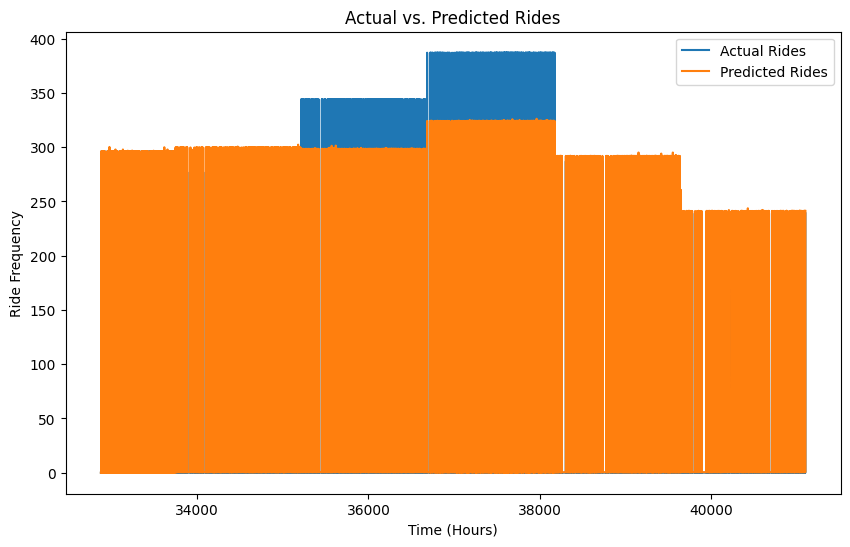

The Mean Squared Error is : 3.1941814830407815


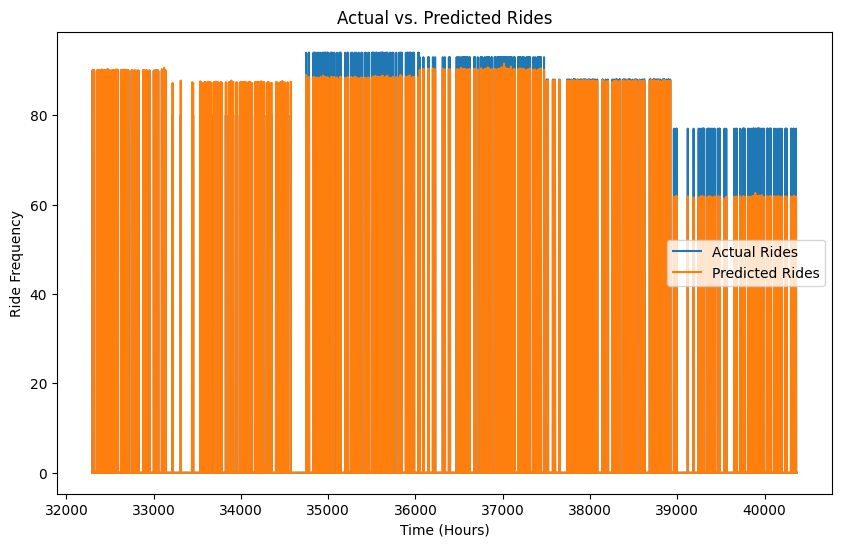

The Mean Squared Error is : 0.03785827961022379


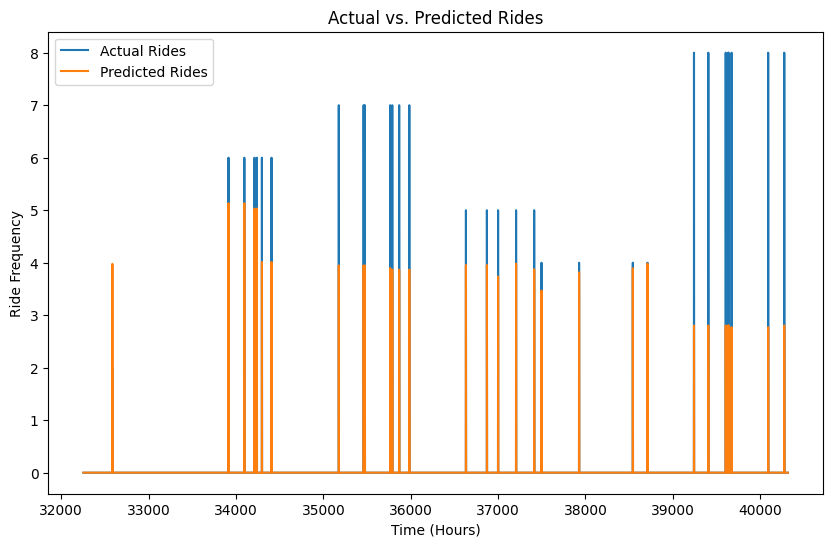

The Mean Squared Error is : 0.0009920634206640835


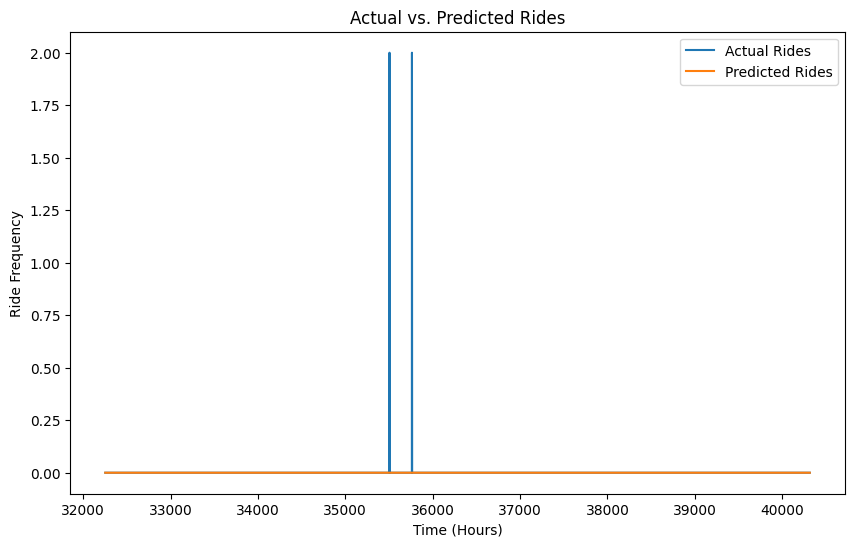

The Mean Squared Error is : 2.344998604189945e-15


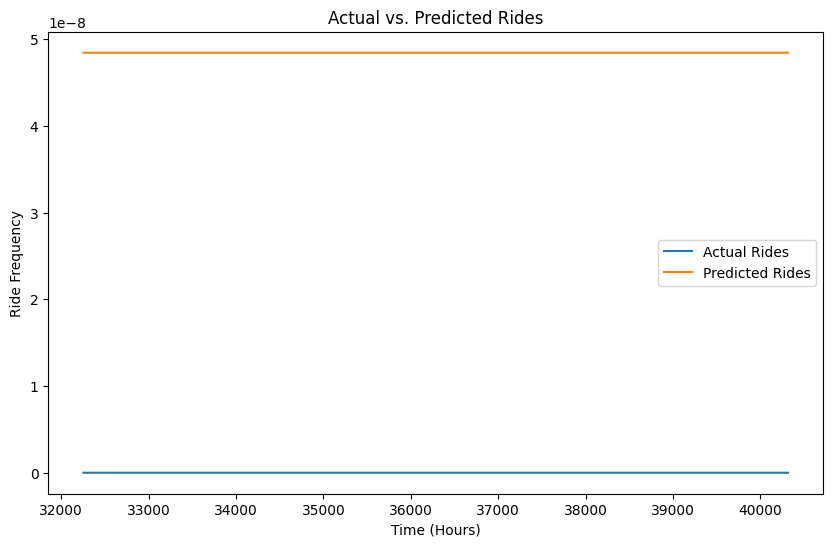

The Mean Squared Error is : 2.5567367837725314e-05


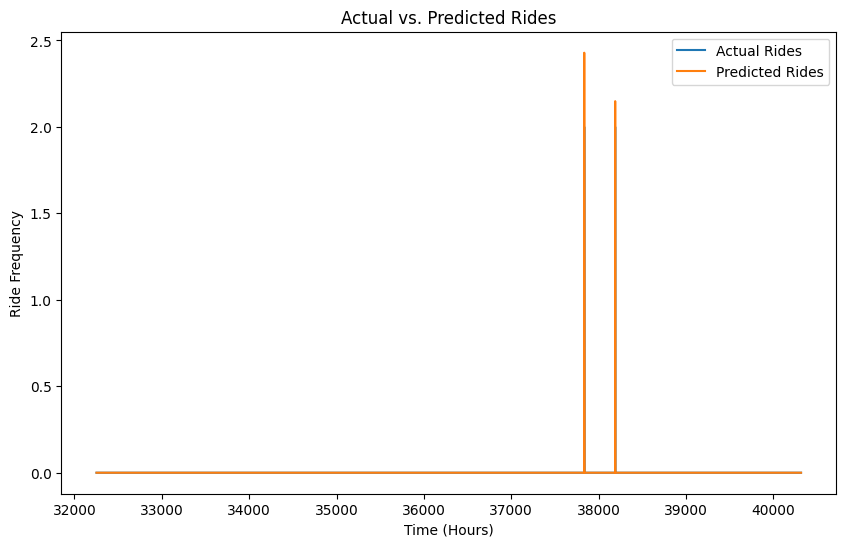

The Mean Squared Error is : 0.00024809970268021767


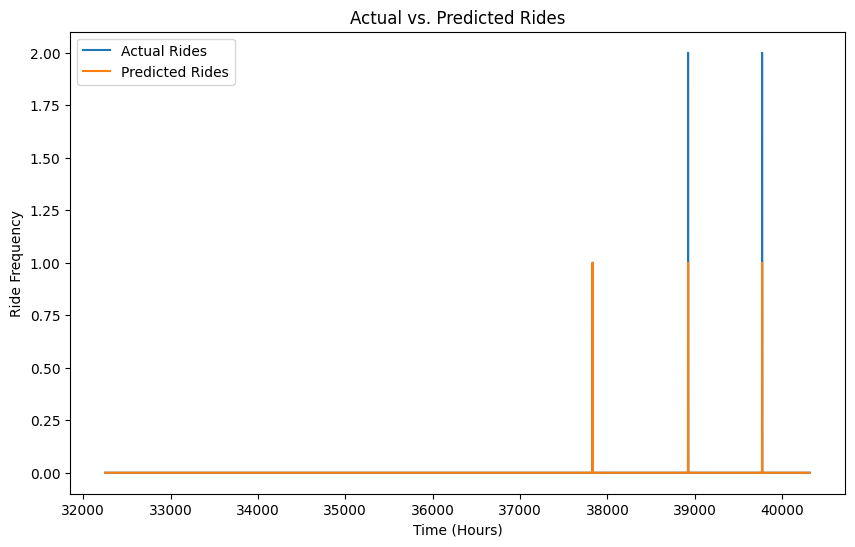

The Mean Squared Error is : 4.346458941236854e-09


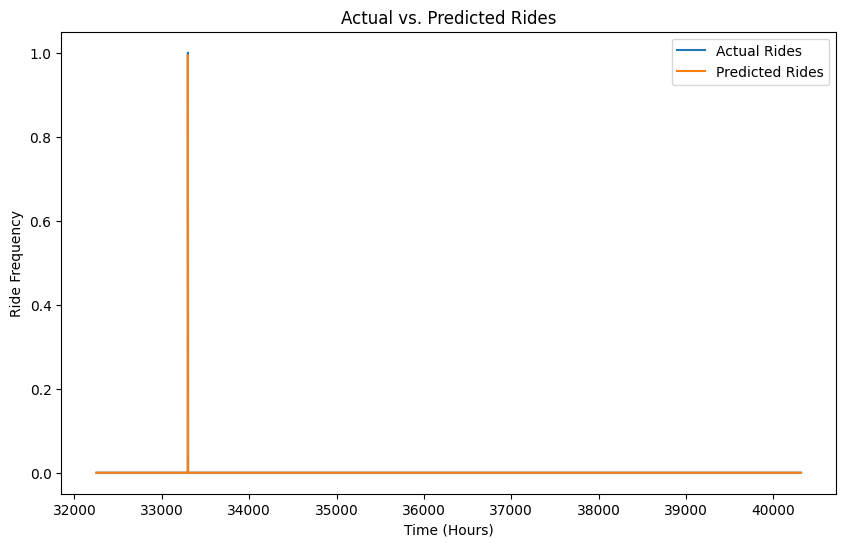

The average Mean Squared Error is : 36.89856777399492


In [39]:
# pre-allocate results
y_predictions = {}
y_train_predictions = {}
pred_times = {}
all_mse = []
count = 1

# loop through hexagon dataframes for modeling
for k, df in hexagon_dict.items():
    
    df_i = hexagon_dict[k]
    
    # train-test split with 80% training and 20% testing data
    split_index = int(0.80 * len(df_i))
    
    train = df_i.iloc[:split_index]
    test = df_i.iloc[split_index:]

    # Separate features (X) and target (y) into train and test data
    X_train = train.drop('starts_count', axis=1)
    y_train = train['starts_count']

    X_test = test.drop('starts_count', axis=1)
    y_test = test['starts_count']

    # Set up the parameter grid for grid search
    param_grid = {
        'n_estimators': [100, 200, 300,400],
        'max_depth': [3, 4, 5,6],
        'learning_rate': [0.01, 0.1, 0.2]
    }

    # initialize XGBoost model
    xgb_model = XGBRegressor(objective='reg:squarederror')

    # perform grid search
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
    grid_search.fit(X_train, y_train)

    # get the best model from grid search
    best_model = grid_search.best_estimator_

    # predict and evaluate using the best model
    y_pred = best_model.predict(X_test)
    y_predictions[k] = y_pred

    mse = mean_squared_error(y_test, y_pred)
    print(f"The Mean Squared Error is : {mse}")
    all_mse.append(mse)

    # Predictions for the training set for plotting
    y_train_pred = best_model.predict(X_train)
    y_train_predictions[k] = y_train_pred

    # plotting the actual vs. predicted values for testing sets
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.index, y_test, label='Actual Rides')
    plt.plot(y_test.index, y_pred, label='Predicted Rides')
    plt.title('Actual vs. Predicted Rides')
    plt.xlabel('Time (Hours)')
    plt.ylabel('Ride Frequency')
    plt.legend()
    plt.show()

    count += 1

    # save time points for prediction
    pred_times[k] = X_test[['day','hour','minute']] 

    # clear variables before the next iteration
    del df_i, split_index, train, test, X_train, y_train, X_test, y_test, xgb_model, y_pred, mse, y_train_pred

print(f"The average Mean Squared Error is : {np.mean(all_mse)}")


The predictions can now be plotted on a heatmap in a similar way as the exploratory data

In [40]:
# take example hexagon
hexagon_id = '85089b1bfffffff'

max_index = np.argmax(y_predictions[hexagon_id])

# retrieve a prediction for a timepoint
frequency = float(y_predictions[hexagon_id][max_index])

# retrieve the day and hour of this prediction
pred_day = pred_times[hexagon_id]['day'].iloc[max_index]
pred_hour = pred_times[hexagon_id]['hour'].iloc[max_index]

# get the hexagon's centroid coordinates
lat, lon = h3.h3_to_geo(hexagon_id)

# folium map centered at the hexagon's centroid
map = folium.Map(location=[lat, lon], zoom_start=12)

# list of points with frequency information
heat_data = [[lat, lon, frequency]]

# Add a HeatMap layer with the frequency information
HeatMap(heat_data, min_opacity=0.2).add_to(map)

# Display the map
print(f"On March {pred_day} at {pred_hour}:00 the model predicts {frequency:.0f} pick ups inside this hexagon (center marked).")
map

On March 26 at 20:00 the model predicts 326 pick ups inside this hexagon (center marked).
